In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# Cross Pollination #
Filter out price outliars?

Graph yTest vs predictions

Average Income for zip code x Sq Foot 

In [ ]:
test_mini = True

# Get Data
data = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')

mini_data = None
if test_mini:
  mini_data = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test_mini.csv')

data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,1565930130,20141104T000000,4,3.25,3760,4675,2.0,0,0,3,...,2740,1020,2007,0,98038,47.3862,-122.048,3280,4033,429900.0
1,3279000420,20150115T000000,3,1.75,1460,7800,1.0,0,0,2,...,1040,420,1979,0,98023,47.3035,-122.382,1310,7865,233000.0
2,194000575,20141014T000000,4,1.00,1340,5800,1.5,0,2,3,...,1340,0,1914,0,98116,47.5658,-122.389,1900,5800,455000.0
3,2115510160,20141208T000000,3,1.75,1440,8050,1.0,0,0,3,...,1440,0,1985,0,98023,47.3187,-122.390,1790,7488,258950.0
4,7522500005,20140815T000000,2,1.50,1780,4750,1.0,0,0,4,...,1080,700,1947,0,98117,47.6859,-122.395,1690,5962,555000.0


In [ ]:
def getHighEnd(view, waterfront, condition):
  multiplier = 5
  if waterfront == 1:
    multiplier = 1

  return (view + 1) * (condition + 1) * multiplier

# Preprocessing
def preprocessing(data: pd.DataFrame):
  data = pd.get_dummies(data, columns=['zipcode'])
  data['high_end'] = data.apply(lambda x: getHighEnd(x['view'], x['waterfront'], x['condition']), axis=1)
  data['sqft_lot_per_15'] = data['sqft_lot'] / data['sqft_lot15']
  data['view_bool'] = data['view'].apply(lambda x: True if x >= 1 else False)

  return data

data = preprocessing(data)

if test_mini:
  mini_data = preprocessing(mini_data)
  _, right = data.align(mini_data, axis=1)
  mini_data = right

In [ ]:
# Get basic stats on the data
mean_price = data['price'].mean()
median_price = data['price'].median() 

In [ ]:
# Set X and y
all_features = [f for f in data if f != 'price' if f != 'date' if f != 'id' #if f != 'zipcode' 
                if f != 'bathrooms' if f != 'view' if f != 'sqft_basement' if f != 'sqft_above']

X = data[all_features]
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Create the model, train it, predictions
model = XGBRegressor(
    n_estimators= 150, # Default is 100
    learning_rate= .15, # default = .1
    grow_policy='lossguide', # Options are 'depthwise' and 'lossguide'
    tree_method = 'auto', # Options are 'approx', 'auto', 'exact', 'gpu_exact', 'gpu_hist', 'hist'
)
model.fit(X_train, y_train)

predictions = model.predict(X_test)

[22:02:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


# METRICS #

In [ ]:
# Compute the Root Mean Squared Error of the predictions
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

rmse = mean_squared_error(y_test, predictions, squared=False)
r2 = r2_score(y_test, predictions)

print(f'Root Mean Squared Error: ${round(rmse, 2):,}')
print(f'Averge Price of House:   ${round(mean_price, 2):,}')
print(f'Median Price of House:   ${round(median_price, 2):,}')
print(f'R2 Score:                {round(r2, 2)}')

Root Mean Squared Error: $130,851.79
Averge Price of House:   $539,436.71
Median Price of House:   $450,000.0
R2 Score:                0.89


In [ ]:
if test_mini:
  miniX = mini_data[all_features]
  miniPredictions = model.predict(miniX)
  
  # place predictions in a dataframe
  miniResults = pd.DataFrame(miniPredictions, columns = ['price'])
  miniResults = miniResults.rename(columns={'price':'dataset'})

  miniResults.to_csv("team2-module3-predictions.csv", index=False)
  print('Exported Mini to CSV')

Exported Mini to CSV


In [ ]:
import seaborn as sns
original_data = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')

data.dtypes

id                   int64
date                object
bedrooms             int64
bathrooms          float64
sqft_living          int64
                    ...   
zipcode_98198        uint8
zipcode_98199        uint8
high_end             int64
sqft_lot_per_15    float64
view_bool             bool
Length: 93, dtype: object

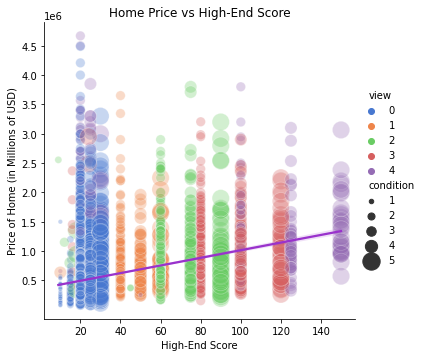

In [ ]:
from matplotlib.pyplot import xticks
import matplotlib.pyplot as plt

# Remove Outliers
data = data[data['price'] < 5000000]

title = "Home Price vs High-End Score"
graph = sns.relplot(data=data, y='price', x='high_end', size='condition', palette='muted', hue='view', sizes=[20, 50, 90, 150, 300], alpha=.3, kind='scatter')
graph.set(yticks=[500000, 1000000, 1500000, 2000000, 2500000, 3000000, 3500000, 4000000, 4500000, 5000000])

sns.regplot(x="high_end", y="price", data=data, x_jitter=1, scatter = False, color='darkorchid');

graph.set(ylabel="Price of Home (in Millions of USD)", xlabel="High-End Score", title=title)

plt.savefig(title, dpi=800, bbox_inches = "tight")
